In [380]:
# imports
import numpy as np
import scipy.io as sio
from skimage.util import montage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

K=10
np.random.seed( 30 )

In [541]:
# plotting 
# Pictures 1x10
def plotPictures(trained_Weight, safeto, save=False):
    s_im =[]
    for label in range(trained_Weight.shape[0]):
        im =  np.transpose(np.reshape(trained_Weight[label, :], (3, 32,32)), (1,2,0))
        im = (im - im.min()) / (im.max() - im.min())
        #np.transpose( im, (1, 0, 2) )
        s_im.append(im)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 10),  # creates 1x10 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, s_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    if save:
        plt.savefig(safeto)
    plt.show()

# plot all graphs
def plotResults(costs_train, accs_train, costs_validate, accs_validate, W, save=False):
    # plotting costs
    plt.plot(costs_train, label = "training")
    plt.plot(costs_validate, label = "validation")
    plt.xlabel('n_epochs')
    plt.ylabel('cost')
    plt.suptitle('Costs')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/2cost.png')
    plt.show()  
    
    # plotting accuracy
    plt.plot(accs_train, label = 'training')
    plt.plot(accs_validate, label = 'validation')
    plt.xlabel('n_epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Accuracy')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/2acc.png')
    plt.show()
    
    # plotting pictures from W
    plotPictures(W, 'Result_Pics/2weights.png', save)


In [532]:
'''Given from template.
Translated form Matlab to Python by someone in the course'''

def ComputeGradsNum(X, Y, P, W, b, lam, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    c = ComputeCost(X, Y, W, b, lam);
    
    for i in range(len(b)):
        #print(i, "out of ", len(b))
        b_try = np.array(b)
        b_try[i] += h
        #print(b_try)
        c2 = ComputeCost(X, Y, W, b_try, lam)
        #print(c)
        #print(c2)
        #print(c2-c)
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        #print(i, "out of ", W.shape[0])
        for j in range(W.shape[1]):
            W_try = W
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lam)
            grad_W[i,j] = (c2-c) / h

    return grad_W, grad_b 

def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));
    
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = ComputeCost(X, Y, W, b_try, lamda)

        b_try = b
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)

        grad_b[i] =  (c2-c1) / (2*h)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = W
            W_try[i,j] -= h
            c1 = ComputeCost(X, Y, W_try, b, lamda)

            W_try = W
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)

            grad_W[i,j] =  (c2-c1) / (2*h)

    return [grad_W, grad_b]

In [539]:
# Exercise 1: Trainin a multi-linear classifier
#functions
# 1. LoadBatch reads reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files
'''
X: image pixel data, has size dxn (3072x10000), is of type double or single and has entries between 0 and 1. 
n: Number of images. here 1000
d: dimensionality of each image(3072=32x32x3)
Y: is Kxn (K= # of labels = 10) and contains the one-hot representation of the label for each image.
y:  is a vector of length n containing the label for each image.
OneHotEncoder: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
'''
def LoadBatch(filename):
    matdata  = sio.loadmat(filename)
    X_images = np.matrix(matdata['data']).astype(float)
    y_labels = np.array(matdata['labels'])
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_onehot = onehot_encoder.fit_transform(y_labels).astype(int)
    return X_images.T,Y_onehot.T,y_labels.T

# 2. Pre-process
'''
mean_X: (dx1) (3072x1)
std_X: (dx1) (3072x1)
'''
def normalize(X):
    mean_X = X.mean(axis=1)
    std_X = X.std(axis=1)
    X_normalized = (X - mean_X) / std_X
    return X_normalized  

# 3. Initialize parameters
np.random.seed( 30 )
def initialize(mean=0.0, std=0.01):
    W = np.random.normal(mean, std, (K,X_train.shape[0])) 
    b = np.random.normal(mean, std, (K,1)) 
    return W,b

# 4. EvaluateClassifier function that evaluates the network function
'''
X: each column of X corresponds to an image and it has size dxn.
W, b: W and b are the parameters of the network.
P: each column of P contains the probability for each label for the image 
in the corresponding column of X. P has size Kxn (10x10000).'''

def EvaluateClassifier(X,W,b):
    s = W*X+b
    p = softmax(s)
    return p

def softmax(scores):
    return np.exp(scores)/np.sum(np.exp(scores), axis=0)

# 5. Compute cost function
'''
X: each column of X corresponds to an image and X has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the 
corresponding column of X or Y is the (1xn) vector of ground truth labels.
J: J is a scalar corresponding to the sum of the loss of the network's
predictions for the images in X relative to the ground truth labels and
the regularization term on W.
'''

def ComputeCost(X, Y, W, b, lam):
    Y = np.reshape(Y, (K, -1))
    N = X.shape[1]
    J = 1/N * (np.sum(LossCrossEntropy(X,Y,W,b)) + lam * np.sum(np.square(W)))
    return J 
    
def LossCrossEntropy(X,Y,W,b):
    p = EvaluateClassifier(X,W,b)
    return - np.log(np.multiply(Y, p).sum(axis=0))

# 6. computes the accuracy of the network's predictions on a set of data.
'''
X: each column of X corresponds to an image and X has size dxn.
y: y is the vector of ground truth labels of length n.
acc: acc is a scalar value containing the accuracy.
'''
def ComputeAccuracy(X, y, W, b):
    p = EvaluateClassifier(X,W,b)
    pred = np.argmax(p, axis=0)
    #print(pred.shape, y.shape)
    same = np.count_nonzero(pred == y)
    #print(same)
    acc = same / X[1].size
    return acc

# 7. function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b
'''
X: each column of X corresponds to an image and it has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the corresponding column of X.
P: each column of P contains the probability for each label for the image in the corresponding column of X. P has size Kxn.
grad_W: grad_W is the gradient matrix of the cost J relative to W and has size Kxd.
def ComputeGradients(X, Y,P, W, lam):
    #P = EvaluateClassifier(X, W,b)
    g_batch = -(Y-P)
    ones =  np.full((X[1].size,1), 1)
    grad_W = 1/X[1].size * g_batch * X.T + 2*lam*W
    grad_b = 1/X[1].size * g_batch * ones
    return grad_W, grad_b    
'''

def ComputeGradients(X, Y, W, lam):
    P = EvaluateClassifier(X,W,b)
    Y = np.reshape(Y, (K, -1))
    N = X[1].size 
    g_batch = -(Y-P)
    ones =  np.full((N,1), 1)

    grad_W = 1/N * g_batch*X.T + 2*lam*W
    grad_b = 1/N* g_batch * ones
    return grad_W, grad_b

def ComputeRelativeError(ga ,gn ,eps):
    #print(np.absolute(np.subtract(ga, gn)))
    #print("max: ",np.maximum( np.full(ga.shape, eps), np.add(np.absolute(ga),np.absolute(gn))))
    return np.absolute(np.subtract(ga, gn)) /  np.maximum(  np.add(np.absolute(ga),np.absolute(gn)), np.full(ga.shape, eps))


In [540]:
# 8. Mini-batch gradient descent algorithm
'''
n_batch: the size of the mini-batches -> number of images in mini-batch
eta: learning rate
n_epochs: number of runs through the whole training set.'''

def GenerateMiniBatches(n_batch, X, Y, permute=False):
    n = X[1].size 
    X_batches = []
    Y_batches = []
    if permute:
        X, Y = shuffle(X.T, Y.T)
        print(X.shape, Y.shape)
        X = X.T
        Y = Y.T
    for j in range(int(n/n_batch)):
        j_start = j*n_batch 
        j_end = (j+1)*n_batch 
        X_batch = X[:, j_start:j_end]
        Y_batch = Y[:, j_start:j_end]
        X_batches.append(X_batch)
        Y_batches.append(Y_batch)
        
    return X_batches, Y_batches
 
# 8. Mini-batch functions
'''
X: all the training images
Y: labels for the training images
W,b: initial values for the network's parameters
lam: regularization factor in the cost function
GDparams: an object containing the parameter values n_batch, eta and n_epochs
'''
def MiniBatchGD(X, Y, y, X_validate, Y_validate, y_validate,  W, b, n_batch=100, eta=0.001,n_epochs=40, lam=0, permute=False):
    costs_train = []
    accs_train = []
    costs_validate = []
    accs_validate  = []
    X_batches, Y_batches = GenerateMiniBatches(n_batch, X, Y, permute)
    #print(X_batches.shape, Y_batches.shape )
    for epoch in range(n_epochs): #iterate over epochs
        print("epoch ",epoch)
        # iterate over mini-batches
        for idx, X_batch in enumerate(X_batches, start=0):
            Y_batch = Y_batches[idx]
            # compute gradients for batch
            grad_W_ana, grad_b_ana = ComputeGradients(X_batch, Y_batch, W, lam)

            # adjust W,b by eta
            W -= eta*grad_W_ana
            b -= eta*grad_b_ana

        # compute cost -> print and save it            
        cost_train = ComputeCost(X, Y, W, b, lam)
        costs_train.append(cost_train)
        print("cost_train: ",cost_train)
        # for validation
        cost_validate = ComputeCost(X_validate, Y_validate, W, b, lam)
        costs_validate.append(cost_validate)
        print("cost_validate: ",cost_validate)
            
        # compute acc -> print and save it
        acc_train = ComputeAccuracy(X, y, W, b)
        accs_train.append(acc_train)
        print("accuracy_train: ",acc_train)
        #for validation
        
        acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)
        print("accuracy_validate: ",acc_validate)

    return costs_train, accs_train, costs_validate, accs_validate

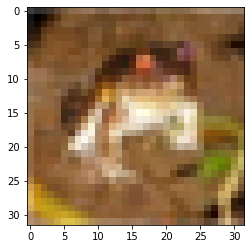

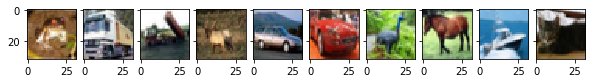

In [536]:
#Loading and exploring data from mat-file 
matdata  = sio.loadmat('Dataset/cifar-10-batches-mat/data_batch_1.mat')
A = matdata['data'] #size 10000 x 3072. row of A.data corresponds to an image of size 32 x 32 x 3 that has been attened into a row vector.
A = np.array(A)
im = np.transpose(np.reshape(A[0, :],(3, 32,32)), (1,2,0))
im = (im - im.min()) / (im.max() - im.min())
plt.imshow(im)

# plot 10 pictures
plotPictures(A[0:10,:], "initial_pics", False)

In [534]:
# 1. Read in and store the training, validation and test data.
print("PART 1: LOAD DATA")
(X_images_train,Y_onehot_train,y_labels_train)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_1.mat')
(X_images_validate,Y_onehot_validate,y_labels_validate)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_2.mat')
(X_images_test,Y_onehot_test,y_labels_test)= LoadBatch('Dataset/cifar-10-batches-mat/test_batch.mat')

# Check the shapes and forms of the loaded data
'''
X (3072x10000) row x column
Y (10x10000)
y (1x10000)
''' 
print("Shapes of loaded data: \n",X_images_train.shape, Y_onehot_train.shape, y_labels_train.shape)
# check one hot encoding structure
print("\nOne hot encoded structure: \n",y_labels_train[:,0], Y_onehot_train[:,0])

# 2. Pre-process
print("\nPART 2: PRE-PROCESS")
X_images_train= normalize(X_images_train)
X_images_validate= normalize(X_images_validate)
X_images_test= normalize(X_images_test)

# check if mean is zero (very small)
mean_X_zero = X_images_train.mean(axis=1)
print("Zero mean values: \n",mean_X_zero)

# 3. Initialize parameters W and b
print("\nPART 3: INITIALIZE PARAMETERS")
'''
W: Kxd (10x3072)
b: Kx1 (10x1)
'''
W,b = initialize()

print("Shapes of W and b: \n",W.shape,b.shape)

#4. Evaluate classifiers
print("\nPART 4: COMPUTE PROBABILITIES")
P = EvaluateClassifier(X_images_train, W,b)

print("Shape of P: \n",P.shape)
print("\nProbabilites for the first image: \n",P[:,0])

#5. Compute cost 
print("\nPART 5: COMPUTE COST")
J = ComputeCost(X_images_train, Y_onehot_train, W, b, 0)

print("Initial cost with lambda = 0: \n",J)

#6. compute accuracy
print("\nPART 6: COMPUTE ACCURACY")
acc = ComputeAccuracy(X_images_train, y_labels_train, W, b)

print("Initial accuracy of predicions: \n",acc)

PART 1: LOAD DATA
Shapes of loaded data: 
 (3072, 10000) (10, 10000) (1, 10000)

One hot encoded structure: 
 [6] [0 0 0 0 0 0 1 0 0 0]

PART 2: PRE-PROCESS
Zero mean values: 
 [[ 1.31672451e-16]
 [-1.00430775e-16]
 [ 1.13975496e-16]
 ...
 [-6.08513240e-17]
 [-8.78241924e-17]
 [ 2.62401212e-17]]

PART 3: INITIALIZE PARAMETERS
Shapes of W and b: 
 (10, 3072) (10, 1)

PART 4: COMPUTE PROBABILITIES
Shape of P: 
 (10, 10000)

Probabilites for the first image: 
 [[0.05834392]
 [0.13510807]
 [0.0511667 ]
 [0.03900748]
 [0.19227041]
 [0.06256219]
 [0.09963376]
 [0.06897453]
 [0.11739009]
 [0.17554285]]

PART 5: COMPUTE COST
Initial cost with lambda = 0: 
 2.360452124448922

PART 6: COMPUTE ACCURACY
Initial accuracy of predicions: 
 0.1246


In [ ]:
#7 compute gradients 
print("\nPART 7: COMPUTE AND TEST GRADIENTS")
'''
print("\nTest1: one picture")
# Analytical gradients
grad_W_ana, grad_b_ana = ComputeGradients_n(X_images_train[:, 1], Y_onehot_train[:, 1], W, 0)
#grad_W_ana, grad_b_ana = computeAnalyticalGradients(X_images_train[:, 1], Y_onehot_train[:, 1], W,P[:, 1], 0)
# Numerical gradients lambda = 0
grad_W_num, grad_b_num = ComputeGradsNum(X_images_train[:, 1], Y_onehot_train[:, 1], P, W, b, 0, 1e-6)
# slow but precise computation
grad_W_num_slow, grad_b_num_slow = ComputeGradsNumSlow(X_images_train[:, 1], Y_onehot_train[:, 1], P, W, b, 0, 1e-6)
# Compute the relative error and check if it is "small"
relative_errors_b = ComputeRelativeError(grad_b_num ,grad_b_ana ,1e-6)
relative_errors_W = ComputeRelativeError(grad_W_num ,grad_W_ana ,1e-6)
#print("Error for gradients for b smaller 1e-6: \n",relative_errors_b < 1e-6)

#print("numerical: \n",grad_W_num ,"\n analytical: \n",grad_W_ana)
#print("Error for gradients for W smaller 1e-6: \n",relative_errors_W )

#grad_W_ana, grad_b_ana = ComputeGradients(X_images_train[0:20, 1], Y_onehot_train[0:20, 1], W[:, 0:20], 0)

# numerical gradients with reduced dimensionality and lambda = 0
#grad_W_num, grad_b_num = ComputeGradsNum(X_images_train[0:20, 1], Y_onehot_train[0:20, 1], P, W[:, 0:20], b, 0, 1e-6)

# slow but precise computation
#grad_W_num_slow, grad_b_num_slow = ComputeGradsNumSlow(X_images_train[:, 1], Y_onehot_train[:, 1], P, W, b, 0, 1e-6)
#grad_W_num_slow, grad_b_num_slow = ComputeGradsNumSlow(X_images_train[0:20, 1], Y_onehot_train[0:20, 1], P, W[:, 0:20], b, 0, 1e-6)

#print(grad_b_num ,grad_b_ana)'''

In [537]:
# Parameters
regularization = 0
n_epochs = 40
n_batch = 100
eta = 0.001
permute = True

# Training
costs_train, accs_train, costs_validate, accs_validate  = MiniBatchGD(X_images_train, Y_onehot_train, y_labels_train, X_images_validate, Y_onehot_validate, y_labels_validate, W, b, n_batch, eta, n_epochs, regularization, permute)

(10000, 3072) (10000, 10)
epoch  0
cost_train:  1.9696538246679092
cost_validate:  1.9971560969063773
accuracy_train:  0.3033
accuracy_validate:  0.2923
epoch  1
cost_train:  1.8943088675689979
cost_validate:  1.9351374816958204
accuracy_train:  0.3431
accuracy_validate:  0.3219
epoch  2
cost_train:  1.8526629918693038
cost_validate:  1.9036998058705392
accuracy_train:  0.3623
accuracy_validate:  0.3361
epoch  3
cost_train:  1.8242808592336726
cost_validate:  1.8838000318106454
accuracy_train:  0.3744
accuracy_validate:  0.3448
epoch  4
cost_train:  1.8028580011390303
cost_validate:  1.8697113135040335
accuracy_train:  0.3839
accuracy_validate:  0.3496
epoch  5
cost_train:  1.785707682240529
cost_validate:  1.8590723138794307
accuracy_train:  0.3898
accuracy_validate:  0.3535
epoch  6
cost_train:  1.7714389411622644
cost_validate:  1.850694920443315
accuracy_train:  0.3932
accuracy_validate:  0.3565
epoch  7
cost_train:  1.7592366027914017
cost_validate:  1.8438985226513156
accuracy_tr

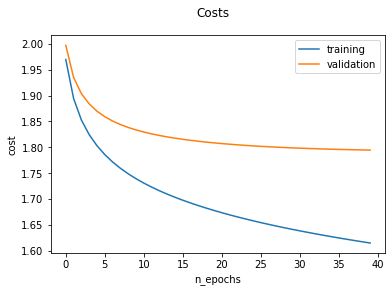

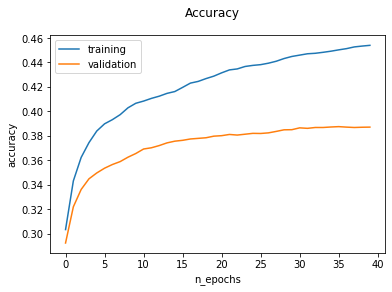

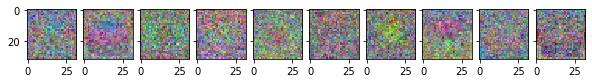

In [543]:
# plotting the resuts
plotResults(costs_train, accs_train, costs_validate, accs_validate, W, False)